In [1]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if "google.colab" in str(get_ipython()):
    print("Installing dependencies using uv...")
    # Install uv if not available
    !pip install -q uv
    # Install system dependencies
    !apt-get install -qq gmsh
    # Use uv to install Python dependencies
    !uv pip install --system matplotlib meshio
    !uv pip install --system "git+https://github.com/smec-ethz/tatva-docs.git"
    print("Installation complete!")

# Periodic Boundary Conditions

We compute the effective (homogenized) stiffness of a periodic composite by solving a **cell problem** on one representative unit cell $\mathcal{A}$.
The microscopic displacement is decomposed as

$$
\boldsymbol{u}(\boldsymbol{y}) = \boldsymbol{E}\,\boldsymbol{y} + \boldsymbol{v}(\boldsymbol{y}),
$$

where $\boldsymbol{E}$ is a prescribed macroscopic strain and $\boldsymbol{v}$ is a periodic fluctuation field.

We solve this example with two approaches:

- We show the use of **Lagrange multipliers** to enforce periodicity. We will solve the saddle-point problem using sparse differentiation and a direct sparse solver. 
- Alternatively, we enforce periodicity through a **MPC** and static condensation, and solve the problem using a matrix-free CG-solver.

We follow Jeremy Bleyer's example:
https://bleyerj.github.io/comet-fenicsx/tours/homogenization/periodic_elasticity/periodic_elasticity.html

$$
\begin{cases}
\nabla\!\cdot\boldsymbol{\sigma}=\boldsymbol{0} & \text{in } \mathcal{A},\\
\boldsymbol{\sigma}=\mathbb{C}(\boldsymbol{y}):\boldsymbol{\varepsilon} & \text{(heterogeneous material)},\\
\boldsymbol{\varepsilon}=\boldsymbol{E}+\nabla^s\boldsymbol{v} & \text{in } \mathcal{A},\\
\boldsymbol{v}\text{ is periodic},\\
\boldsymbol{T}=\boldsymbol{\sigma}\boldsymbol{n}\text{ is anti-periodic.}
\end{cases}
$$

Because the framework is fully differentiable, we can obtain $\mathbb{C}^{\text{hom}}$ directly by differentiating the map $\boldsymbol{E} \mapsto \langle\boldsymbol{\sigma}(\boldsymbol{E})\rangle$, rather than solving separate problems for multiple $\boldsymbol{E}$.


In [2]:
import gmsh
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array
from tatva import Mesh, Operator, compound, element

jax.config.update("jax_enable_x64", True)

## Meshing

We build a periodic unit square with circular inclusions using `gmsh`.
Two physical regions are extracted:

- **Matrix** elements
- **Inclusions** elements

Boundary edges are also tagged (`left`, `right`, `top`, `bottom`) so we can later pair nodes and impose periodicity.


In [3]:
# [collapse: code] Code for mesh generation and extraction

from itertools import chain
from typing import TypedDict


class PhysicalGroups(TypedDict):
    Matrix: Array
    Inclusions: Array
    bottom: Array
    right: Array
    top: Array
    left: Array


def plot_mesh(mesh: Mesh, pg: PhysicalGroups, ax: plt.Axes | None = None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    ax.triplot(
        mesh.coords[:, 0], mesh.coords[:, 1], mesh.elements, color="gray", linewidth=0.5
    )
    # Plot physical groups with different colors
    ax.tricontourf(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        jnp.zeros(mesh.coords.shape[0]).at[pg["Inclusions"]].set(1.0),
        levels=[-0.5, 0.5, 1.5],
        colors=["C0", "C1"],
        alpha=0.3,
    )  # ty: ignore
    ax.set_aspect("equal")


def extract_physical_groups(tag_map: dict) -> PhysicalGroups:
    print("Extracting physical groups from Gmsh model...")
    physical_surfaces: dict[str, Array] = {}

    for dim, pg_tag in chain(
        gmsh.model.getPhysicalGroups(dim=1), gmsh.model.getPhysicalGroups(dim=2)
    ):
        name = gmsh.model.getPhysicalName(dim, pg_tag)

        # Entities (surface tags) that belong to this physical group
        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, pg_tag)

        els = []
        for ent in entities:
            # Get all mesh elements on this surface entity
            types, _, node_tags_by_type = gmsh.model.mesh.getElements(dim, ent)

            for etype, ntags in zip(types, node_tags_by_type):
                nodes = np.array(ntags, dtype=np.int64).reshape(-1, etype + 1)
                els.append(nodes)

        if not els:
            physical_surfaces[name] = np.zeros((0, dim + 1), dtype=np.int32)
            continue

        group_els = np.vstack(els, dtype=np.int32)
        group_els = np.array(
            [[tag_map[t] for t in tri] for tri in group_els], dtype=np.int32
        )
        physical_surfaces[name] = group_els

    return physical_surfaces


def extract_mesh_data() -> tuple[Array, Array, PhysicalGroups]:
    # Extract nodes and elements
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    tag_map = {tag: i for i, tag in enumerate(node_tags)}
    nodes = jnp.array(node_coords).reshape(-1, 3)[:, :2]

    elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(2)
    elements = jnp.array(elem_node_tags[0]).reshape(-1, 3) - 1

    pg = extract_physical_groups(tag_map)
    return nodes, elements, pg


def generate_mesh(
    Lx: float, Ly: float, c: float, R: float, h: float
) -> tuple[Mesh, PhysicalGroups, NDArray]:
    corners = np.array([[0.0, 0.0], [Lx, 0.0], [Lx + c, Ly], [c, Ly]])
    a1 = corners[1, :] - corners[0, :]  # first vector generating periodicity
    a2 = corners[3, :] - corners[0, :]  # second vector generating periodicity

    gdim = 2  # domain geometry dimension
    fdim = 1  # facets dimension
    gmsh.initialize()

    occ = gmsh.model.occ
    model_rank = 0
    points = [occ.add_point(*corner, 0) for corner in corners]
    lines = [occ.add_line(points[i], points[(i + 1) % 4]) for i in range(4)]
    loop = occ.add_curve_loop(lines)
    unit_cell = occ.add_plane_surface([loop])
    inclusions = [occ.add_disk(*corner, 0, R, R) for corner in corners]
    vol_dimTag = (gdim, unit_cell)
    out = occ.intersect(
        [vol_dimTag], [(gdim, incl) for incl in inclusions], removeObject=False
    )
    incl_dimTags = out[0]
    occ.synchronize()
    occ.cut([vol_dimTag], incl_dimTags, removeTool=False)
    occ.synchronize()

    # tag physical domains and facets
    gmsh.model.addPhysicalGroup(gdim, [vol_dimTag[1]], 1, name="Matrix")
    gmsh.model.addPhysicalGroup(
        gdim,
        [tag for _, tag in incl_dimTags],
        2,
        name="Inclusions",
    )
    gmsh.model.addPhysicalGroup(fdim, [7, 20, 10], 1, name="bottom")
    gmsh.model.addPhysicalGroup(fdim, [9, 19, 16], 2, name="right")
    gmsh.model.addPhysicalGroup(fdim, [15, 18, 12], 3, name="top")
    gmsh.model.addPhysicalGroup(fdim, [11, 17, 5], 4, name="left")
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h)

    gmsh.model.mesh.generate(gdim)

    nodes, elements, pg = extract_mesh_data()
    mesh = Mesh(coords=nodes, elements=elements)
    gmsh.finalize()
    return mesh, pg, corners

In [4]:
# [output: hide]
Lx = 1.0
Ly = np.sqrt(3) / 2.0 * Lx
c = 0.5 * Lx
R = 0.2 * Lx
h = 0.02 * Lx

mesh, pg, corners = generate_mesh(Lx, Ly, c, R, h)

Info    : Meshing 1D...ence                                                                                                                      
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Ellipse)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Ellipse)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Ellipse)
Info    : [ 60%] Meshing curve 14 (Ellipse)
Info    : [ 70%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 80%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [ 90%] Meshing curve 19 (Line)
Info    : [100%] Meshing curve 20 (Line)
Info    : Done meshing 1D (Wall 0.000598198s, CPU 0.00099s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Fro

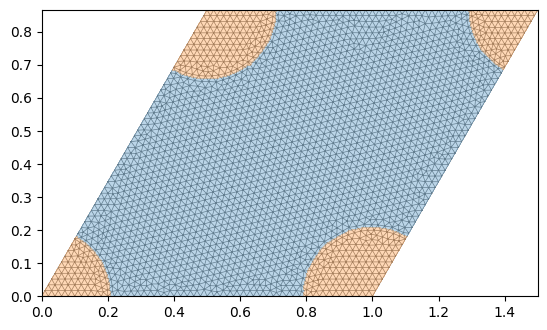

In [5]:
plot_mesh(mesh, pg)

## Problem setup

### Material

We define isotropic linear elasticity for each phase through Lame parameters $(\mu,\lambda)$.
The local constitutive law is

$$
\boldsymbol{\sigma} = 2\mu\,\boldsymbol{\varepsilon} + \lambda\,\mathrm{tr}(\boldsymbol{\varepsilon})\,\mathbf{I}.
$$

For a given macroscopic strain $\boldsymbol{E}=\hat{\boldsymbol{\varepsilon}}$, the cell energy density uses

$$
\boldsymbol{\varepsilon}(\boldsymbol{u}) = \nabla^s\boldsymbol{u} + \hat{\boldsymbol{\varepsilon}}.
$$

This lets us solve the microscopic fluctuation while embedding the imposed macro-strain.


In [6]:
from typing import NamedTuple

from jax_autovmap import autovmap


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # Lamé parameter

    @classmethod
    def from_youngs_poisson_2d(
        cls, E: float, nu: float, plane_stress: bool = False
    ) -> "Material":
        mu = E / 2 / (1 + nu)
        if plane_stress:
            lmbda = 2 * nu * mu / (1 - nu)
        else:
            lmbda = E * nu / (1 - 2 * nu) / (1 + nu)
        return cls(mu=mu, lmbda=lmbda)


mat_matrix = Material.from_youngs_poisson_2d(50e3, 0.2)
mat_inclusion = Material.from_youngs_poisson_2d(210e3, 0.3)


@autovmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    return 2 * mu * eps + lmbda * jnp.trace(eps) * jnp.eye(2)


@autovmap(grad_u=2, eps_hat=2, mu=0, lmbda=0)
def strain_energy(grad_u, eps_hat, mu, lmbda):
    """Includes macroscopic strain eps_hat."""
    eps = compute_strain(grad_u) + eps_hat
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)

### Periodic mapping

Periodic kinematics require matching opposite boundary nodes:

- left $\leftrightarrow$ right
- bottom $\leftrightarrow$ top

The helper `edge_bijection` builds slave-to-master pairs by geometric matching.
Corner nodes are handled separately to avoid duplicate constraints.


In [7]:
from numpy.typing import NDArray

ArrayLike = NDArray | Array

mesh_matrix = mesh._replace(elements=pg["Matrix"])
mesh_inclusion = mesh._replace(elements=pg["Inclusions"])
op_matrix = Operator(mesh_matrix, element.Tri3())
op_inclusion = Operator(mesh_inclusion, element.Tri3())
op = Operator(mesh, element.Tri3())


def edge_bijection(
    coords: ArrayLike,
    m_group: ArrayLike,
    s_group: ArrayLike,
    *,
    axis: int = 0,
    offset: float = 0.0,
) -> Array:
    """Find a bijection between master and slave edge nodes. Returns an array of sorted
    slave node indices such that s_nodes[i] -> m_nodes[i]
    """
    axis = axis ^ 1  # bitwise xor to get the other axis
    m_nodes = jnp.unique(m_group)
    s_nodes = jnp.unique(s_group)

    # exclude corners from the matching (min and max in axis direction)
    m_nodes = m_nodes[
        (coords[m_nodes, axis] != jnp.min(coords[m_nodes, axis]))
        & (coords[m_nodes, axis] != jnp.max(coords[m_nodes, axis]))
    ]
    s_nodes = s_nodes[
        (coords[s_nodes, axis] != jnp.min(coords[s_nodes, axis]))
        & (coords[s_nodes, axis] != jnp.max(coords[s_nodes, axis]))
    ]

    # for each m_node, find the closest s_node depending on the periodicity vector
    def find_closest_slave(m_node: ArrayLike, inv_axis: int) -> ArrayLike:
        diffs = coords[s_nodes, inv_axis] - (coords[m_node, inv_axis] + offset)
        return jnp.array([m_node, s_nodes[jnp.argmin(diffs**2)]])

    return jax.vmap(find_closest_slave, in_axes=(0, None))(m_nodes, axis)


corner_nodes = [
    jnp.argmin(jnp.linalg.norm(mesh.coords - corner, axis=1)) for corner in corners
]
corner_m = jnp.repeat(corner_nodes[0], 3)
corner_s = jnp.array(corner_nodes[1:])
left_right = edge_bijection(mesh.coords, pg["left"], pg["right"], axis=0)
bottom_top = edge_bijection(
    mesh.coords, pg["bottom"], pg["top"], axis=1, offset=Lx * 1 / 2
)
corner_map = jnp.vstack([corner_m, corner_s]).T

## PBCs with Lagrange Multipliers

We create a `Compound` subclass with two fields:
- $\mathbf{u}$: the periodic displacement fluctuation field `(n_nodes, 2)`
- $\lambda$: the lagrange multipliers `(n_slave_nodes, 2)`


In [8]:
import jax.experimental.sparse as jsparse
import scipy.sparse as sp
from tatva.lifter import DirichletBC, Lifter
from tatva.sparse import create_sparsity_pattern, reduce_sparsity_pattern


class SolutionLM(compound.Compound):
    u = compound.field(mesh.coords.shape)
    lm = compound.field(
        (left_right.shape[0] + bottom_top.shape[0] + corner_s.shape[0], 2)
    )

In [9]:
# [collapse: code] Code for augmenting sparsity pattern with dense constraint blocks (e.g., for Lagrange multipliers)
def add_dense_matrix_to_sparsity(
    base_sparsity: jsparse.BCOO, B: Array, C_full: bool = False
) -> jsparse.BCOO:
    """Augment a base sparsity pattern with dense constraint blocks.

    Args:
        base_sparsity: Base sparsity pattern for the primal block.
        B: Dense constraint coupling block to be appended.
        C_full: Whether to use a dense (True) or identity (False) constraint block.

    Returns:
        Combined sparsity pattern including the constraint blocks.
    """
    nb_cons = B.shape[0]
    B_sparsity_pattern = jsparse.BCOO.fromdense(B).astype(jnp.int32)
    BT_sparsity_pattern = jsparse.BCOO.fromdense(B.T).astype(jnp.int32)
    if C_full:
        c_dense = jnp.ones((nb_cons, nb_cons))
    else:
        c_dense = jnp.eye(nb_cons, nb_cons)
    C = jsparse.BCOO.fromdense(c_dense).astype(jnp.int32)

    sp_left = jsparse.bcoo_concatenate([base_sparsity, B_sparsity_pattern], dimension=0)
    sp_right = jsparse.bcoo_concatenate([BT_sparsity_pattern, C], dimension=0)
    full_sparsity = jsparse.bcoo_concatenate([sp_left, sp_right], dimension=1)
    return full_sparsity


In [17]:
def constraints_func(u_flat: Array) -> Array:
    """A function that returns the residual of the periodicity constraints, which should
    be zero at the solution. The Lagrange multipliers will enforce these constraints.
    """
    (u, _) = SolutionLM(u_flat)
    u_diff_left_right = u[left_right[:, 0]] - u[left_right[:, 1]]
    u_diff_bot_top = u[bottom_top[:, 0]] - u[bottom_top[:, 1]]
    u_diff_corners = u[corner_m] - u[corner_s]
    return jnp.concatenate(
        [
            u_diff_left_right.flatten(),
            u_diff_bot_top.flatten(),
            u_diff_corners.flatten(),
        ]
    )


### Sparsity and graph coloring

In [16]:
from tatva_coloring import distance2_color_and_seeds

# generate base sparsity pattern for the primal block
sparsity = create_sparsity_pattern(mesh, 2)
# add dense blocks for the coupling constraints with Lagrange multipliers
sparsity = add_dense_matrix_to_sparsity(
    sparsity,
    jax.jacfwd(constraints_func)(jnp.zeros(SolutionLM.size))[
        :, : -(SolutionLM.lm.shape[0] * 2)
    ],
    C_full=False,  # only coupling constraints, no dense interactions between Lagrange multipliers themselves
)

# we use a lifter to restrict rigid body modes
lifter = Lifter(
    SolutionLM.size,
    DirichletBC(SolutionLM.u[[corner_m[0]]]),
)

sparsity = reduce_sparsity_pattern(sparsity, lifter.free_dofs)
sparsity_csr = sp.csr_matrix(
    (sparsity.data, (sparsity.indices[:, 0], sparsity.indices[:, 1])),
    shape=sparsity.shape,
)

colors = distance2_color_and_seeds(
    sparsity_csr.indptr, sparsity_csr.indices, sparsity.shape[0]
)[0]

print(f"Number of colors required: {jnp.max(colors) + 1}")

Number of colors required: 26


### Energy functional and sparse Jacobian

The total cell energy is the sum of matrix and inclusion contributions:

$$
\Pi(\mathbf{u};\hat{\boldsymbol{\varepsilon}})=\int_{\mathcal{A}_m}\psi_m\,dA+\int_{\mathcal{A}_i}\psi_i\,dA.
$$

We minimize in reduced variables by composing with the lifter,
$\Pi_r(\mathbf{v}) = \Pi(\text{lift}(\mathbf{v}))$.

`jax.jacrev` gives the residual, and a colored sparse Jacobian is assembled for efficient linear solves.


In [26]:
from tatva import sparse


def total_energy(u: Array, eps_hat: Array) -> Array:
    # compute energy contributions from matrix and inclusion domains
    e_inclusion = op_inclusion.integrate(
        strain_energy(
            op_inclusion.grad(u), eps_hat, mat_inclusion.mu, mat_inclusion.lmbda
        )
    )
    e_matrix = op_matrix.integrate(
        strain_energy(op_matrix.grad(u), eps_hat, mat_matrix.mu, mat_matrix.lmbda)
    )
    return e_inclusion + e_matrix


def lagrangian(u_flat: Array, eps_hat: Array) -> Array:
    (u, lm) = SolutionLM(u_flat)

    # add contribution from Lagrange multipliers enforcing periodicity constraints
    return total_energy(u, eps_hat) + jnp.dot(lm.flatten(), constraints_func(u_flat))


def lagrangian_free(u_free: Array, eps_hat: Array) -> Array:
    u_full = lifter.lift_from_zeros(u_free)
    return lagrangian(u_full, eps_hat)


residual = jax.jacrev(lagrangian_free)
jacobian = sparse.jacfwd(
    residual, sparsity_csr.indptr, sparsity_csr.indices, colors, has_aux_args=True
)

### Solve for unit strains

We solve three independent 2D strain load cases (Voigt basis):

- $\varepsilon_{xx}=1$
- $\varepsilon_{yy}=1$
- $\varepsilon_{xy}=1$ (implemented with symmetric $0.5$ off-diagonals)

For each case, we solve the linearized equilibrium for fluctuation DOFs, then reconstruct

$$
\boldsymbol{u}(\boldsymbol{y}) = \hat{\boldsymbol{\varepsilon}}\,\boldsymbol{y} + \tilde{\boldsymbol{u}}(\boldsymbol{y}).
$$


In [30]:
# [collapse: code] Newton-Krylov solver with sparse direct solver for the linearized system.

from functools import partial


@partial(jax.jit, static_argnames=["gradient", "compute_tangent"])
def newton_krylov_solver(
    u,
    gradient,
    compute_tangent,
):
    residual = gradient(u)
    norm_res = jnp.linalg.norm(residual)

    init_val = (u, 0, norm_res)

    def cond_fun(state):
        u, iiter, norm_res = state
        return jnp.logical_and(norm_res > 1e-8, iiter < 10)

    def body_fun(state):
        u, iiter, norm_res = state
        residual = gradient(u)

        A = jax.jit(partial(compute_tangent, u_prev=u))

        du, _ = jax.scipy.sparse.linalg.cg(A=A, b=-residual)

        u = u + du

        residual = gradient(u)
        norm_res = jnp.linalg.norm(residual)

        return (u, iiter + 1, norm_res)

    final_u, final_iiter, final_norm = jax.lax.while_loop(cond_fun, body_fun, init_val)
    jax.debug.print("  Residual: {res:.2e}", res=final_norm)

    return final_u, final_norm


In [32]:
from dataclasses import dataclass


def sparse_solve(A: jsparse.BCOO, b: Array) -> Array:
    return jsparse.linalg.spsolve(A.data, sparsity_csr.indices, sparsity_csr.indptr, b)


@dataclass
class Result:
    u: NDArray
    eps_hat: NDArray


v0 = jnp.zeros(lifter.size_reduced)

scale = 0.3
eps_hat_list = scale * jnp.array(
    [
        [[1.0, 0.0], [0.0, 0.0]],
        [[0.0, 0.0], [0.0, 1.0]],
        [[0.0, 0.5], [0.5, 0.0]],
    ]
)  # unit strain tensors

results = []

for eps_hat in eps_hat_list[:]:
    v = sparse_solve(jacobian(v0, eps_hat), -residual(v0, eps_hat))
    u0 = (eps_hat @ mesh.coords.T).T
    u = u0 + SolutionLM(lifter.lift_from_zeros(v)).u
    results.append(Result(u=u, eps_hat=eps_hat))

### Results

In [ ]:
# [collapse: code] Functions for post-processing and visualization of results
from matplotlib.cm import ScalarMappable
from matplotlib.tri import Triangulation
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.collections import LineCollection

import numpy as np


def cell_to_point_data(
    coords: np.ndarray,
    elements: np.ndarray,
    celldata: np.ndarray,
    *,
    method: str = "area",
    eps: float = 1e-30,
) -> np.ndarray:
    """Interpolate (average) per-cell data to nodes for a 2D triangular mesh.

    Args:
        coords: float
        elements: (node indices per triangle)
        celldata: (nels, ...) float  (e.g. stress components per element)
        method: "uniform" or "area"
            - "uniform": each incident element contributes equally
            - "area"   : each incident element weighted by triangle area
        eps: small number to avoid divide-by-zero

    Returns:
        pointdata: (nnodes, ...) float
    """
    coords = np.asarray(coords)
    elements = np.asarray(elements, dtype=np.int64)
    celldata = np.asarray(celldata)

    nnodes = coords.shape[0]
    nels = elements.shape[0]

    # Flatten celldata trailing dims -> (nels, ncomp)
    trailing_shape = celldata.shape[1:]
    cel_flat = celldata.reshape(nels, -1)
    ncomp = cel_flat.shape[1]

    # Optional weights per element
    if method == "uniform":
        w = np.ones(nels, dtype=cel_flat.dtype)
    elif method == "area":
        tri = coords[elements]  # (nels, 3, 2)
        a = tri[:, 1] - tri[:, 0]
        b = tri[:, 2] - tri[:, 0]
        # signed area*2 = cross(a,b) in 2D
        w = 0.5 * np.abs(a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0])
        w = w.astype(cel_flat.dtype, copy=False)
    else:
        raise ValueError("method must be 'uniform' or 'area'")

    # Accumulate: for each element, add w*celldata to its 3 nodes
    point_sum = np.zeros((nnodes, ncomp), dtype=cel_flat.dtype)
    weight_sum = np.zeros(nnodes, dtype=cel_flat.dtype)

    contrib = cel_flat * w[:, None]  # (nels, ncomp)
    for j in range(3):
        idx = elements[:, j]
        np.add.at(point_sum, idx, contrib)
        np.add.at(weight_sum, idx, w)

    point_flat = point_sum / (weight_sum[:, None] + eps)
    return point_flat.reshape((nnodes,) + trailing_shape)


def stress(u: Array) -> Array:
    """Computes the stress respecting the two separate materials."""
    grad_u = op.grad(u).squeeze()
    eps = compute_strain(grad_u)
    sig_1 = compute_stress(eps, mat_matrix.mu, mat_matrix.lmbda)
    sig_2 = compute_stress(eps, mat_inclusion.mu, mat_inclusion.lmbda)
    mask = jnp.isin(op.mesh.elements, mesh_inclusion.elements).all(axis=1)  # (nels,)
    sig = jnp.where(mask[:, None, None], sig_2, sig_1)
    return sig


def von_mises_2d(sig: Array) -> Array:
    sxx = sig[..., 0, 0]
    syy = sig[..., 1, 1]
    sxy = sig[..., 0, 1]
    return jnp.sqrt(sxx**2 - sxx * syy + syy**2 + 3 * sxy**2)


In [ ]:
# [collapse: code] Matplotlib settings for plotting
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}",
        "grid.color": "grey",
        "grid.linestyle": "solid",
        "grid.linewidth": 0.25,
        "grid.alpha": 0.2,
        "figure.dpi": 200,
    }
)

/tmp/ipykernel_98198/2498942156.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


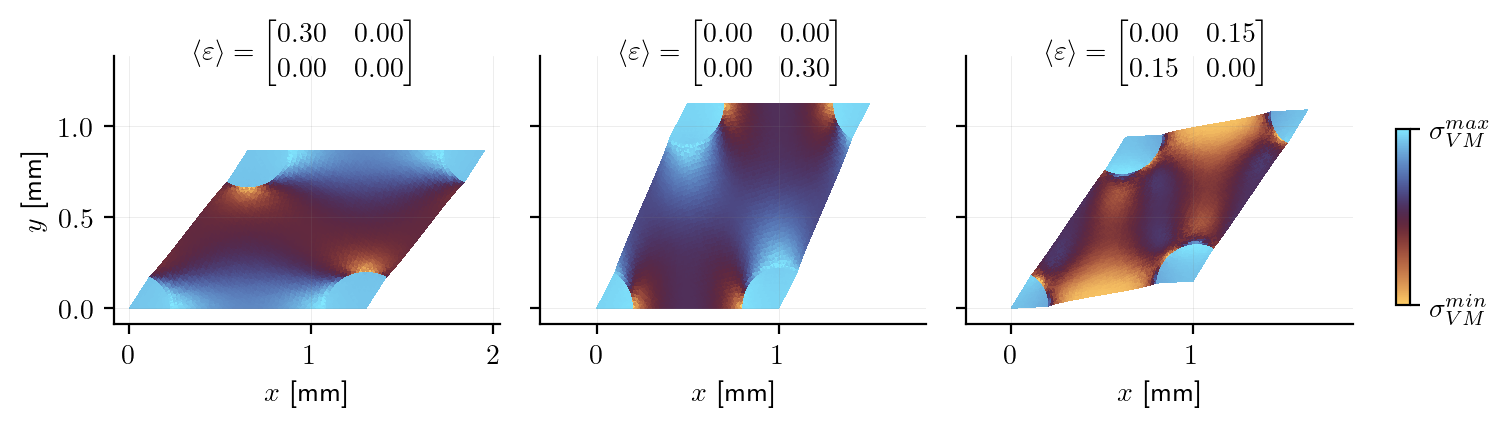

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(7.1, 2.2), sharey=True)

sig_vm_min = np.inf
sig_vm_max = -np.inf

for res in results:
    sig = stress(res.u)
    sig_vm = von_mises_2d(sig)
    sig_vm_min = min(sig_vm_min, jnp.min(sig_vm))
    sig_vm_max = max(sig_vm_max, jnp.max(sig_vm))

for i, (ax, res) in enumerate(zip(axes, results)):
    ax: plt.Axes
    x = mesh.coords + res.u
    tri = Triangulation(x[:, 0], x[:, 1], triangles=np.array(mesh.elements))
    sig = stress(res.u)
    sig_vm = von_mises_2d(sig)

    m = ax.tripcolor(tri, facecolors=sig_vm, cmap="managua", rasterized=True)
    ax.set_aspect("equal", adjustable="datalim")
    # keep axes size consistent
    ax.set_ylim(-0.1 * Ly, Ly * 1.6)
    ax.grid()
    ax.set_xlabel("$x$ [mm]")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.annotate(
        r"$$\langle\varepsilon\rangle = \begin{bmatrix}"
        + f"{res.eps_hat[0, 0]:.2f} & {res.eps_hat[0, 1]:.2f} \\\\ "
        + f"{res.eps_hat[1, 0]:.2f} & {res.eps_hat[1, 1]:.2f} "
        + r"\end{bmatrix}$$",
        xy=(0.5, 0.89),
        ha="center",
        va="bottom",
        xycoords="axes fraction",
    )

axes[0].set(ylabel="$y$ [mm]")
cax = fig.add_axes((1.0, 0.3, 0.01, 0.4))
sm = ScalarMappable(Normalize(vmin=0, vmax=1), cmap="managua")
cb = fig.colorbar(sm, cax=cax, orientation="vertical", pad=0.1)
cb.set_ticks([0, 1])
cb.set_ticklabels((r"$\sigma_{{VM}}^{{min}}$", r"$\sigma_{{VM}}^{{max}}$"))

plt.tight_layout()

### Compute homogenized stiffness tensor

From each solved microfield, we compute element stresses and average them over the cell:

$$
\langle \boldsymbol{\sigma} \rangle = \frac{1}{|\mathcal{A}|}\int_{\mathcal{A}} \boldsymbol{\sigma}\,dA.
$$

The homogenized tangent in Voigt form is obtained by automatic differentiation of
$\langle\boldsymbol{\sigma}\rangle(\hat{\boldsymbol{\varepsilon}})$:

$$
\mathbf{C}^{\text{hom}} = \frac{\partial\langle\boldsymbol{\sigma}\rangle}{\partial\hat{\boldsymbol{\varepsilon}}}.
$$

!!! note

    Unfortunately, the sparse solver of `jax` is not differentiable yet. Therefore, we use a dense direct solver for this part of the example.

In [ ]:
jacobian_dense = jax.jacfwd(residual)


def func(eps_hat_voigt: Array) -> Array:
    """Returns the average stress for a given macroscopic strain eps_hat (in Voigt notation)."""
    eps_hat = jnp.array(
        [[eps_hat_voigt[0], eps_hat_voigt[2]], [eps_hat_voigt[2], eps_hat_voigt[1]]]
    )
    v = jnp.linalg.solve(jacobian_dense(v0, eps_hat), -residual(v0, eps_hat))
    u = (eps_hat @ mesh.coords.T).T + SolutionLM(lifter.lift_from_zeros(v)).u
    sig = stress(u)
    sig = jnp.mean(sig, axis=0)  # average stress
    return jnp.array([sig[0, 0], sig[1, 1], sig[0, 1]])


C_hom = jax.jacfwd(func)(jnp.ones(3))

In [66]:
print("Homogenized stiffness tensor (Voigt notation):")
with np.printoptions(precision=2):
    print(C_hom)

Homogenized stiffness tensor (Voigt notation):
[[6.58e+04 1.75e+04 8.28e+01]
 [1.75e+04 6.57e+04 1.44e+02]
 [5.57e+01 8.66e+01 4.82e+04]]


## PBCs through condensation

We create a `Compound` subclass with one field:
- $\mathbf{u}$: the periodic displacement fluctuation field `(n_nodes, 2)`

[`Lifter`](../api/tatva.lifter.md#tatva.lifter.Lifter) enforces constraints in reduced coordinates.
We define:

- `PeriodicMap(slave, master)` for periodic DOF ties
- one `DirichletBC` at a corner to remove rigid-body translation

Then the solver unknown is only the **free DOF vector** $\mathbf{v}$, while `lifter.lift_from_zeros(v)` reconstructs the full constrained field.


In [84]:
from tatva.sparse import reduce_sparsity_pattern
from tatva.lifter import PeriodicMap, Lifter, DirichletBC
from tatva.sparse._extraction import create_sparsity_pattern_master_slave


class Solution(compound.Compound):
    u = compound.field(mesh.coords.shape)


periodic_map = jnp.concatenate(
    [
        jnp.array([Solution.u[nodes, :] for nodes in left_right.T]).T,
        jnp.array([Solution.u[nodes, :] for nodes in bottom_top.T]).T,
        jnp.array([Solution.u[nodes, :] for nodes in corner_map.T]).T,
    ]
)

lifter = Lifter(
    Solution.size,
    DirichletBC(Solution.u[[corner_m[0]]]),
    PeriodicMap(periodic_map[:, 1], periodic_map[:, 0]),
)

sparsity = create_sparsity_pattern_master_slave(
    mesh,
    2,
    jnp.arange(Solution.size)
    .at[Solution.u[[corner_m[0]]]]
    .set(-1)
    .at[periodic_map[:, 1]]
    .set(periodic_map[:, 0]),
)

### Energy functional

The total cell energy is the sum of matrix and inclusion contributions:

$$
\Pi(\mathbf{u};\hat{\boldsymbol{\varepsilon}})=\int_{\mathcal{A}_m}\psi_m\,dA+\int_{\mathcal{A}_i}\psi_i\,dA.
$$

We minimize in reduced variables by composing with the lifter,
$\Pi_r(\mathbf{v}) = \Pi(\text{lift}(\mathbf{v}))$.

`jax.jacrev` gives the residual, and `jax.jvp` defines the Jacobian-Vector-Product function.


In [87]:
from typing import Callable
import scipy.sparse as sp
from tatva import sparse


def total_energy(u_flat: Array, eps_hat: Array) -> Array:
    (u,) = Solution(u_flat)
    # Inclusion gets Material 2, Matrix gets Material 1
    e_inclusion = op_inclusion.integrate(
        strain_energy(
            op_inclusion.grad(u), eps_hat, mat_inclusion.mu, mat_inclusion.lmbda
        )
    )
    e_matrix = op_matrix.integrate(
        strain_energy(op_matrix.grad(u), eps_hat, mat_matrix.mu, mat_matrix.lmbda)
    )
    return e_inclusion + e_matrix


def lagrangian(u_free: Array, eps_hat: Array) -> Array:
    u_full = lifter.lift_from_zeros(u_free)
    return total_energy(u_full, eps_hat)


residual = jax.jacrev(lagrangian)


def jvp(loc: Array, eps_hat: Array) -> Callable[[Array], Array]:
    def _jvp_fn(v: Array) -> Array:
        return jax.jvp(residual, (loc, eps_hat), (v, jnp.zeros_like(eps_hat)))[1]

    return _jvp_fn

### Solve for unit strains

We solve three independent 2D strain load cases (Voigt basis):

- $\varepsilon_{xx}=1$
- $\varepsilon_{yy}=1$
- $\varepsilon_{xy}=1$ (implemented with symmetric $0.5$ off-diagonals)

For each case, we solve the linearized equilibrium for fluctuation DOFs, then reconstruct

$$
\boldsymbol{u}(\boldsymbol{y}) = \hat{\boldsymbol{\varepsilon}}\,\boldsymbol{y} + \tilde{\boldsymbol{u}}(\boldsymbol{y}).
$$


In [88]:
from dataclasses import dataclass

import jax.experimental.sparse as jsparse


@dataclass
class Result:
    u: NDArray
    eps_hat: NDArray


v0 = jnp.zeros(lifter.size_reduced)

scale = 0.3
eps_hat_list = scale * jnp.array(
    [
        [[1.0, 0.0], [0.0, 0.0]],
        [[0.0, 0.0], [0.0, 1.0]],
        [[0.0, 0.5], [0.5, 0.0]],
    ]
)  # unit strain tensors

results = []

for eps_hat in eps_hat_list:
    v = jax.scipy.sparse.linalg.cg(jvp(v0, eps_hat), -residual(v0, eps_hat))[0]
    u0 = (eps_hat @ mesh.coords.T).T
    u = u0 + Solution(lifter.lift_from_zeros(v)).u
    results.append(Result(u=u, eps_hat=eps_hat))

### Results

/tmp/ipykernel_98198/830935014.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


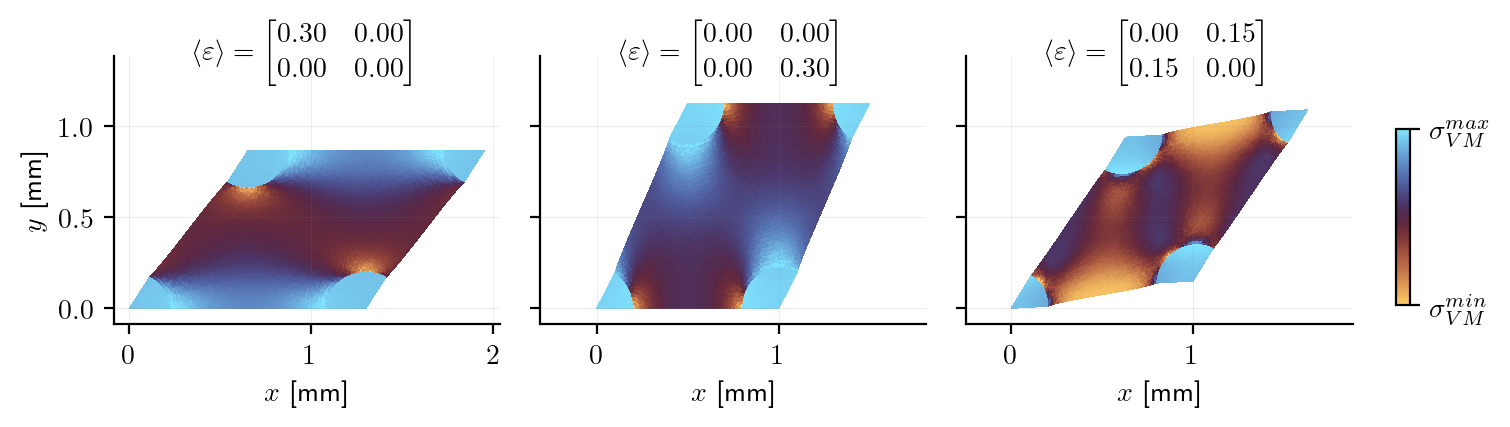

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(7.1, 2.2), sharey=True)

sig_vm_min = np.inf
sig_vm_max = -np.inf

for res in results:
    sig = stress(res.u)
    sig_vm = von_mises_2d(sig)
    sig_vm_min = min(sig_vm_min, jnp.min(sig_vm))
    sig_vm_max = max(sig_vm_max, jnp.max(sig_vm))

for i, (ax, res) in enumerate(zip(axes, results)):
    ax: plt.Axes
    x = mesh.coords + res.u
    tri = Triangulation(x[:, 0], x[:, 1], triangles=np.array(mesh.elements))
    sig = stress(res.u)
    sig_vm = von_mises_2d(sig)

    m = ax.tripcolor(tri, facecolors=sig_vm, cmap="managua", rasterized=True)
    ax.set_aspect("equal", adjustable="datalim")
    # keep axes size consistent
    ax.set_ylim(-0.1 * Ly, Ly * 1.6)
    ax.grid()
    ax.set_xlabel("$x$ [mm]")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.annotate(
        r"$$\langle\varepsilon\rangle = \begin{bmatrix}"
        + f"{res.eps_hat[0, 0]:.2f} & {res.eps_hat[0, 1]:.2f} \\\\ "
        + f"{res.eps_hat[1, 0]:.2f} & {res.eps_hat[1, 1]:.2f} "
        + r"\end{bmatrix}$$",
        xy=(0.5, 0.89),
        ha="center",
        va="bottom",
        xycoords="axes fraction",
    )

axes[0].set(ylabel="$y$ [mm]")
cax = fig.add_axes((1.0, 0.3, 0.01, 0.4))
sm = ScalarMappable(Normalize(vmin=0, vmax=1), cmap="managua")
cb = fig.colorbar(sm, cax=cax, orientation="vertical", pad=0.1)
cb.set_ticks([0, 1])
cb.set_ticklabels((r"$\sigma_{{VM}}^{{min}}$", r"$\sigma_{{VM}}^{{max}}$"))

plt.tight_layout()

### Compute homogenized stiffness tensor

From each solved microfield, we compute element stresses and average them over the cell:

$$
\langle \boldsymbol{\sigma} \rangle = \frac{1}{|\mathcal{A}|}\int_{\mathcal{A}} \boldsymbol{\sigma}\,dA.
$$

The homogenized tangent in Voigt form is obtained by automatic differentiation of
$\langle\boldsymbol{\sigma}\rangle(\hat{\boldsymbol{\varepsilon}})$:

$$
\mathbf{C}^{\text{hom}} = \frac{\partial\langle\boldsymbol{\sigma}\rangle}{\partial\hat{\boldsymbol{\varepsilon}}}.
$$


In [ ]:
def func(eps_hat_voigt: Array) -> Array:
    eps_hat = jnp.array(
        [[eps_hat_voigt[0], eps_hat_voigt[2]], [eps_hat_voigt[2], eps_hat_voigt[1]]]
    )
    v = jax.scipy.sparse.linalg.cg(jvp(v0, eps_hat), -residual(v0, eps_hat))[0]
    u = (eps_hat @ mesh.coords.T).T + Solution(lifter.lift_from_zeros(v)).u
    sig = stress(u)
    sig = jnp.mean(sig, axis=0)  # average stress
    return jnp.array([sig[0, 0], sig[1, 1], sig[0, 1]])


C_hom = jax.jacfwd(func)(jnp.ones(3))

In [95]:
print("Homogenized stiffness tensor (Voigt notation):")
with np.printoptions(precision=2):
    print(C_hom)

Homogenized stiffness tensor (Voigt notation):
[[6.58e+04 1.75e+04 8.28e+01]
 [1.75e+04 6.57e+04 1.44e+02]
 [5.57e+01 8.66e+01 4.82e+04]]
